# K-Means

K-means is an unsupervised-learning algorithm which separates the data into $k$ different clusters. The algorithm works by minimizing the sum of squares of the samples within each cluster. A cluster $\it{S}_j$ is represented by its centroid $m_j$. A certain sample $x_i$ belongs to a cluster $\it{S}_j$ if $m_j$ is the closest centroid among all centroids. A cluster is conformed then by:
$$
\it{S}_j = \{x_i : \|x_i - m_j\|_2 < \|x_i - m_p\|_2 \forall p, 1\leq p\leq K, p \neq j\}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from models.k_means import KMeans
from utils.datasets import blobs_classification_dataset
from utils.visualization import plot_decision_boundary
from utils.metrics import prediction_strength

In [2]:
%matplotlib inline

np.random.seed(1)

### Fitting 4 true clusters with different values of k

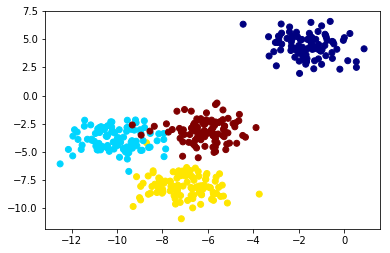

In [3]:
(x_train, y_train), (_, _) = blobs_classification_dataset(features=2, classes=4, samples=500)

# Visualize
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In [4]:
# Initialize and fit the model
model3 = KMeans(k=3)
model3.fit(x_train)

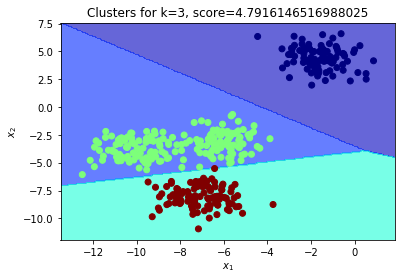

In [5]:
# Visualize decision boundary
y_hat, score = model3.predict(x_train, score=True)

ax = plot_decision_boundary(model3.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1], classes=5)
ax.scatter(x_train[:, 0], x_train[:, 1], c=model3.predict(x_train), cmap='jet', label='True classes')
plt.title("Clusters for k={}, score={}".format(3, score))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

### Define cross-validation to asses the quality of k
Due to the random initialization, k-means does not always converge to the same solution for the same data and number of clusters to. To more confidently asses the quality of the hyper-parameter k we can use cross-validation.

In [6]:
def cross_validate(model, X, f=5):
    X_fold = X
    pivot = int(X_fold.shape[0]/f)
    cum_score = 0
    for _ in range(f):
        # Always take firt fold as test
        x_test = X_fold[:pivot, :]
        x_train = X_fold[pivot:, :]
        
        # fit the model
        model.fit(X=x_train, verbose=False)
        y_hat, score = model.predict(x_test, score=True)
        
        cum_score += score
        
        X_fold = np.concatenate((x_train, x_test))
        
    return cum_score/f

In [7]:
score = cross_validate(model3, x_train)
print("Validated score for k=3, score={}".format(score))

Validated score for k=3, score=5.100500061825491


### Prediction Strength of a clustering algorithm

Another way to determine the quality of a clustering algorithm is to use the *prediction strength*. This metric measures the proportion of points in a test set that are assigned to the same cluster by both, a model trained in the test set and a model trained in the train set. It takes as reference the clustering of the model trained in the test set, for each cluster computes the proportion of pair of points in that cluster that are assigned to the same cluster by the model trained in the train set. A rule of thumb when using this metric is to use the biggest value of k such that the predictions score is 0.8or higher.

In [8]:
# Prediction strength for k = 3
ps = prediction_strength(model3, x_train)

print('k=3, prediction strength: {}'.format(ps))

k=3, prediction strength: 1.024390243902439


This allow us to use cross_validation using this metric.

In [9]:
def cross_validatePS(model, X, f=5):
    X_fold = X
    pivot = int(X_fold.shape[0]/f)
    cum_score = 0
    for _ in range(f):
        # Always take firt fold as test
        x_test = X_fold[:pivot, :]
        x_train = X_fold[pivot:, :]
        
        # Asses the model
        score = prediction_strength(model, x_train, x_test)
        cum_score += score
        
        X_fold = np.concatenate((x_train, x_test))
        
    return cum_score/f

In [10]:
# Prediction strength for k = 3
ps = cross_validatePS(model3, x_train)

print('k=3, prediction strength: {}'.format(ps))

k=3, prediction strength: 0.9199110060013833


### Search for optimum value of k

Take the value higher value of k such that the computed prediction score is 0.8 or higher

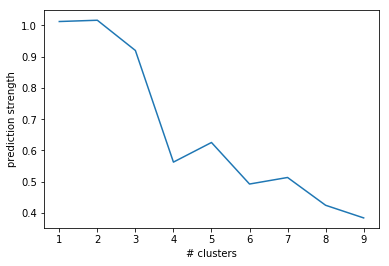

In [11]:
K = np.arange(1, 10)
scores = []
best_score = float('inf')
for k in K:
    model = KMeans(k=k)
    scores.append(cross_validatePS(model, x_train))
    if scores[-1]>=0.8:
        best_score = scores[-1]
        best_model = model
        best_k = k
    
    
# Display results
plt.plot(K, scores)
plt.xlabel('# clusters')
plt.ylabel('prediction strength')
plt.show()

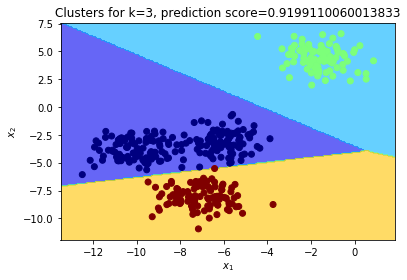

In [12]:
# Visualize decision boundary
best_model.fit(x_train)
y_hat, score = best_model.predict(x_train, score=True)

ax = plot_decision_boundary(best_model.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1], classes=best_k)
ax.scatter(x_train[:, 0], x_train[:, 1], c=best_model.predict(x_train), cmap='jet', label='True classes')
plt.title("Clusters for k={}, prediction score={}".format(best_k, best_score))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()